ใน ep นี้เราจะ

# 0. Install

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Install Library ที่จำเป็น

In [3]:
## Colab
! curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


เช็ค GPU

In [1]:
! nvidia-smi

Mon Dec 16 09:20:14 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 1. Import

Import Library ที่จะใช้ ในที่นี้คือ fastai และ fastai.text 

In [0]:
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.callbacks.mem import *

In [0]:
# import fastai.utils.collect_env
# fastai.utils.collect_env.show_install()

สำหรับ [Google Colab](https://www.bualabs.com/archives/1687/what-is-colab-open-jupyter-notebook-in-github-on-google-colab-create-open-in-colab-button-colab-ep-1/) เราจะกำหนด path ที่เก็บ DataSet และ Mount Google Drive 

In [6]:
dataset = '26i-giga-fren'

# Google Colab
config_path = Path('/content/drive')
data_path_base = Path('/content/datasets/')

data_path = data_path_base/dataset

from google.colab import drive
drive.mount(str(config_path))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 2. Dataset

ในเคสนี้เราจะใช้ Human Numbers คือ รายการตัวเลข เขียนเป็นภาษาอังกฤษ 

In [7]:
data_path

PosixPath('/content/datasets/26i-giga-fren')

In [8]:
! wget https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz -P {data_path}

--2019-12-16 09:22:10--  https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.4.22
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.4.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598183296 (2.4G) [application/x-tar]
Saving to: ‘/content/datasets/26i-giga-fren/giga-fren.tgz’

giga-fren.tgz       100%[===================>]   2.42G  16.6MB/s    in 2m 32s  

2019-12-16 09:24:43 (16.3 MB/s) - ‘/content/datasets/26i-giga-fren/giga-fren.tgz’ saved [2598183296/2598183296]



In [0]:
! tar xf {data_path}/giga-fren.tgz -C {data_path}

In [10]:
path = data_path/'giga-fren'
path.ls()

[PosixPath('/content/datasets/26i-giga-fren/giga-fren/giga-fren.release2.fixed.fr'),
 PosixPath('/content/datasets/26i-giga-fren/giga-fren/giga-fren.release2.fixed.en')]

In [11]:
! head {path}/giga-fren.release2.fixed.en

Changing Lives | Changing Society | How It Works | Technology Drives Change Home | Concepts | Teachers | Search | Overview | Credits | HHCC Web | Reference | Feedback Virtual Museum of Canada Home Page
Site map
Feedback
Credits
Français
What is light ?
The white light spectrum Codes in the light The electromagnetic spectrum Emission spectra Absorption spectra Light-years Light pollution
The sky of the first inhabitants A contemporary vison of the Universe Astronomy for everyone
Cartoon
Links


In [12]:
! head {path}/giga-fren.release2.fixed.fr

Il a transformé notre vie | Il a transformé la société | Son fonctionnement | La technologie, moteur du changement Accueil | Concepts | Enseignants | Recherche | Aperçu | Collaborateurs | Web HHCC | Ressources | Commentaires Musée virtuel du Canada
Plan du site
Rétroaction
Crédits
English
Qu’est-ce que la lumière?
La découverte du spectre de la lumière blanche Des codes dans la lumière Le spectre électromagnétique Les spectres d’émission Les spectres d’absorption Les années-lumière La pollution lumineuse
Le ciel des premiers habitants La vision contemporaine de l'Univers L’astronomie pour tous
Bande dessinée
Liens


# 3. Preprocess

In [0]:
def readfile(d): return [o.strip() for o in open(path/d).readlines()]

In [0]:
# fr = readfile(path/'giga-fren.release2.fixed.fr')
# len(fr)

In [0]:
# en = readfile(path/'giga-fren.release2.fixed.en')
# len(en)

ใช้ [RegEx](https://www.bualabs.com/archives/3070/what-is-regular-expression-regex-regexp-teach-how-to-regex-python-nlp-ep-7/) สกัด เอาเฉพาะประโยคคำถามภาษาอังกฤษออกมา ที่ขึ้นต้นด้วย "Wh" และ ลงท้ายด้วย "?" และประโยคภาษาฝรั่งเศสที่คู่กัน ที่ลงท้ายด้วย ?

In [0]:
re_eq = re.compile('^(Wh[^?.!]+\?)')
re_fq = re.compile('^([^?.!]+\?)')
en_fname = path/'giga-fren.release2.fixed.en'
fr_fname = path/'giga-fren.release2.fixed.fr'

In [0]:
lines = ((re_eq.search(eq), re_fq.search(fq))
            for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))
qs = [(e.group(), f.group()) for e, f in lines if e and f]

In [0]:
qs = [(q1, q2) for q1, q2 in qs]

df = pd.DataFrame({'fr': [q[1] for q in qs], 'en': [q[0] for q in qs]}, columns=['en', 'fr'])
df.to_csv(path/'questions_easy.csv', index=False)

In [20]:
path.ls()

[PosixPath('/content/datasets/26i-giga-fren/giga-fren/giga-fren.release2.fixed.fr'),
 PosixPath('/content/datasets/26i-giga-fren/giga-fren/giga-fren.release2.fixed.en'),
 PosixPath('/content/datasets/26i-giga-fren/giga-fren/questions_easy.csv')]

DataBunch

In [26]:
df = pd.read_csv(path/'questions_easy.csv')
df.head()

,en,fr
0,What is light ?,Qu’est-ce que la lumière?
1,Who are we?,Où sommes-nous?
2,Where did we come from?,D'où venons-nous?
3,What would we do without it?,Que ferions-nous sans elle ?
4,What is the absolute location (latitude and lo...,Quelle sont les coordonnées (latitude et longi...


เพื่อให้ง่ายขึ้น เราจะแปลงเป็นตัวเล็กให้หมด

In [0]:
df['en'] = df['en'].apply(lambda x: x.lower())
df['fr'] = df['fr'].apply(lambda x: x.lower())

In [28]:
df.head()

,en,fr
0,what is light ?,qu’est-ce que la lumière?
1,who are we?,où sommes-nous?
2,where did we come from?,d'où venons-nous?
3,what would we do without it?,que ferions-nous sans elle ?
4,what is the absolute location (latitude and lo...,quelle sont les coordonnées (latitude et longi...


ประกาศฟังก์ชัน เรียงรวมข้อมูล ใส่ padding และ เรียงย้อนจากหลังมาหน้า ตามที่กำหนด

In [0]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    samples = to_data(samples)
    max_len_x, max_len_y = max([len(s[0]) for s in samples]), max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx

    if backwards: pad_first = not pad_first
    for i, s in enumerate(samples): 
        if pad_first:
            res_x[i, -len(s[0]):], res_y[i, -len(s[1]):] = LongTensor(s[0]), LongTensor(s[1])
        else:
            res_x[i, :len(s[0]):], res_y[i, :len(s[1]):] = LongTensor(s[0]), LongTensor(s[1])
    if backwards: res_x, res_y = res_x.flip(1), res_y.flip(1)
    return res_x, res_y

In [0]:
class Seq2SeqDataBunch(TextDataBunch):
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', 
               bs:int=32, val_bs:int=None, pad_idx=1, dl_tfms=None, 
               pad_first=False, device:torch.device=None, no_check:bool=False, 
               backwards:bool=False, **dl_kwargs) -> DataBunch:

        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, 
                             pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, 
                                       key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)


Random Sampler แต่ให้เรียงภายใน Batch เนื่องจากประโยคควรเรียง

In [0]:
# SortishSampler??

In [0]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

กำหนด Data Pipeline ด้วย Data Block API ให้ข้อมูลตัวอย่าง x เป็นประโยคภาษาฝรั่งเศส และ Label y เป็นประโยคภาษาอังกฤษ

In [33]:
src = Seq2SeqTextList.from_df(df, path=path, cols='fr').split_by_rand_pct(seed=42).label_from_df(cols='en', label_cls=TextList)

ดูตำแหน่ง Token ที่ความยาว 90% 

ได้โดยเฉลี่ยไม่เกิน 28 Token สำหรับภาษาฝรั่งเศส และ 23 Token สำหรับ ภาษาอังกฤษ

In [34]:
np.percentile([len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items], 90)

28.0

In [35]:
np.percentile([len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items], 90)

23.0

เพื่อความง่าย เราจะลบ ประโยคที่ยาวกว่า 30 Token ในภาษาใดภาษาหนึ่ง (ไม่ถึง 10%) ทิ้งไป

In [0]:
src = src.filter_by_func(lambda x, y: len(x) > 30 or len(y) > 30)

เหลือ 48350 คู่ประโยค

In [37]:
len(src.train) + len(src.valid)

48350

In [0]:
data = src.databunch()

Save ไว้ก่อน คราวหน้าจะได้ไม่ต้อง Preprocess ใหม่

In [0]:
data.save()

In [40]:
data

Seq2SeqDataBunch;

Train: LabelList (38704 items)
x: Seq2SeqTextList
xxbos qu’est - ce que la lumière ?,xxbos où sommes - nous ?,xxbos d'où venons - nous ?,xxbos que ferions - nous sans elle ?,xxbos quel est le groupe autochtone principal sur l’île de vancouver ?
y: TextList
xxbos what is light ?,xxbos who are we ?,xxbos where did we come from ?,xxbos what would we do without it ?,xxbos what is the major aboriginal group on vancouver island ?
Path: /content/datasets/26i-giga-fren/giga-fren;

Valid: LabelList (9646 items)
x: Seq2SeqTextList
xxbos quels pourraient être les effets sur l’instrument de xxunk et sur l’aide humanitaire qui ne sont pas co - xxunk ?,xxbos quand la source primaire a - t - elle été créée ?,xxbos pourquoi tant de soldats ont - ils fait xxunk de ne pas voir ce qui s'est passé le 4 et le 16 mars ?,xxbos quels sont les taux d'impôt sur le revenu au canada pour 2007 ?,xxbos pourquoi le programme devrait - il intéresser les employeurs et les fournisseurs de services ?


In [41]:
path

PosixPath('/content/datasets/26i-giga-fren/giga-fren')

In [0]:
data = load_data(path)

In [43]:
data.show_batch()

text,target
"xxbos quels services offrez - vous aux résidents , par l'entremise de votre propre organisation , par l'entremise de liens / partenariats avec des organismes communautaires ou les deux ?",xxbos which of the following services do you offer to residents either through your own organization or through linkages and / or partnerships with community agencies or both ?
"xxbos quelles initiatives ont été prises , conformément aux recommandations précédentes du comité , pour sensibiliser tant les hommes que les femmes à la contraception et aux méthodes xxunk ?","xxbos what steps have been taken , in line with the committee ’s previous recommendations , to raise awareness about contraception and xxunk methods among both men and women ?"
xxbos qu’en est - il d’un leader qui ne possède que deux de ces caractéristiques ou de celui qui ne manifeste que de temps en temps certains comportements xxunk ?,xxbos what if a leader xxunk only two of the factors ?
"xxbos quels mécanismes d'évaluation , de surveillance ou de responsabilisation sont en place pour l'étude de cas , tant dans le cadre de l'initiative qu'à l'intérieur de votre organisation ?","xxbos what evaluation , monitoring or other accountability mechanisms are in place for this work , within the initiative and within your organization ?"
"xxbos quelles sont les hypothèses , selon la définition actuelle du développement , do nt les pays en développement sont censés s'inspirer pour réformer leurs systèmes de politique sociale ?",xxbos what are the assumptions in the current understanding of development that developing countries are expected to accommodate in reforming their social - policy systems ?


# 4. Model

แทนที่จะเทรนแต่ต้นทั้งหมด เราจะใช้ Transfer Learning เพื่อประหยัดเวลา และเพิ่มประสิทธิภาพ 

## 4.1 Embedding

โดยในส่วนของ Word Embedding เราจะใช้ Pre-trained Word Vector จาก FastText ที่เทรนด้วยข้อมูลจาก Common Crawl และ Wikipedia ด้วยวิธี Continuous Bag of Words (CBOW) จะอธิบายต่อไป

In [44]:
! pip install fasttext

     |████████████████████████████████| 61kB 2.0MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.1-cp36-cp36m-linux_x86_64.whl size=2386192 sha256=3f45b7604bdcc19695ec75219cec7abe44836d0bac24bbd2ed307487cf5ca59e
  Stored in directory: /root/.cache/pip/wheels/9f/f0/04/caa82c912aee89ce76358ff954f3f0729b7577c8ff23a292e3
Successfully built fasttext


In [0]:
import fasttext as ft

In [46]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -P {path}
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz -P {path}

--2019-12-16 09:40:20--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.6.166, 104.20.22.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.6.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘/content/datasets/26i-giga-fren/giga-fren/cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  13.0MB/s    in 5m 37s  

2019-12-16 09:45:57 (12.8 MB/s) - ‘/content/datasets/26i-giga-fren/giga-fren/cc.en.300.bin.gz’ saved [4503593528/4503593528]

--2019-12-16 09:46:00--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:16a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HT

In [0]:
! gunzip {path}/cc.en.300.bin.gz
! gunzip {path}/cc.fr.300.bin.gz

In [48]:
fr_vecs = ft.load_model(str((path/'cc.fr.300.bin')))
en_vecs = ft.load_model(str((path/'cc.en.300.bin')))

ประกาศฟังก์ชัน สร้าง Embedding จาก Pre-trained Vector และเติมค่า Vector คำศัพท์ที่ขาดหายไปด้วย ค่า Random

In [0]:
def create_emb(vecs, itos, em_sz=300, multi=1.):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    vec_dic = {w: vecs.get_word_vector(w) for w in vecs.get_words()}
    miss = []
    for i, w in enumerate(itos):
        try: wgts[i] = tensor(vec_dic[w])
        except: miss.append(w)
    return emb

In [0]:
emb_enc = create_emb(fr_vecs, data.x.vocab.itos)
emb_dec = create_emb(en_vecs, data.y.vocab.itos)

In [51]:
emb_enc.weight.size(), emb_dec.weight.size()

(torch.Size([11336, 300]), torch.Size([8144, 300]))

In [0]:
model_path = config_path/'My Drive/models'

In [53]:
torch.save(emb_enc, model_path/'fr_emb.pth')
torch.save(emb_dec, model_path/'en_emb.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
emb_enc = torch.load(model_path/'fr_emb.pth')
emb_dec = torch.load(model_path/'en_emb.pth')

## 4.2 Sequence to Sequence Model

โมเดลของเราจะแบ่งเป็น 2 ส่วนคือ Encoder แปลงข้อความภาษาอังกฤษ เป็น Vector และ Coder ที่จะ Generate ข้อความภาษาอังกฤษ จาก Vector นั้น

In [0]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl, self.nh, self.out_sl = nl, nh, out_sl
        self.bos_idx, self.pad_idx = bos_idx, pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings

        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl, 
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)

        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl, 
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data

    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h

    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:, 0]))
        return h, outp
    
    def forward(self, inp):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx

        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            dec_inp = outp.max(1)[1]
            res.append(outp)
            if (dec_inp==self.pad_idx).all(): break
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs):
        return one_param(self).new_zeros(self.nl, bs, self.nh)


In [0]:
xb, yb = next(iter(data.valid_dl))

In [57]:
xb.shape

torch.Size([64, 30])

In [0]:
rnn = Seq2SeqRNN(emb_enc, emb_dec, 256, 30)

In [59]:
rnn

Seq2SeqRNN(
  (emb_enc): Embedding(11336, 300, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15, inplace=False)
  (gru_enc): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.25)
  (out_enc): Linear(in_features=256, out_features=300, bias=False)
  (emb_dec): Embedding(8144, 300, padding_idx=1)
  (gru_dec): GRU(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (out_drop): Dropout(p=0.35, inplace=False)
  (out): Linear(in_features=300, out_features=8144, bias=True)
)

In [60]:
len(xb[0])

30

In [0]:
h = rnn.encoder(64, xb.cpu())

In [62]:
h.size()

torch.Size([2, 64, 300])

## 4.3 Loss Function

In [0]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs, targ_len = targ.size()
    _, out_len, vs = out.size()
    if targ_len > out_len: out = F.pad(out, (0, 0, 0, targ_len-out_len, 0, 0), value=pad_idx)
    if out_len > targ_len: targ = F.pad(targ, (0, out_len-targ_len, 0, 0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

In [0]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs, targ_len = targ.size()
    _, out_len, vs = out.size()
    if targ_len > out_len: out = F.pad(out, (0, 0, 0, targ_len-out_len, 0, 0), value=pad_idx)
    if out_len > targ_len: targ = F.pad(targ, (0, out_len-targ_len, 0, 0), value=pad_idx)
    out = out.argmax(2)
    return (out == targ).float().mean()

# 5. Train Model

## 5.1 Train โมเดลที่สร้างไว้ด้านบน

In [0]:
learn = Learner(data, rnn, loss_func=seq2seq_loss, callback_fns=[ShowGraph], metrics=[seq2seq_acc])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


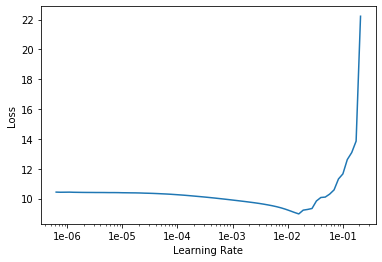

In [66]:
learn.lr_find()
learn.recorder.plot(suggest=True)

แต่ Accuracy เป็น Metrics ที่ไม่ค่อยเหมาะสำหรับงาน Translation สักเท่าไร

epoch,train_loss,valid_loss,seq2seq_acc,time
0,5.959682,5.781046,0.244028,00:28
1,5.060291,4.567313,0.361465,00:27
2,4.641746,4.581412,0.349070,00:28
3,3.983043,4.589123,0.348913,00:29


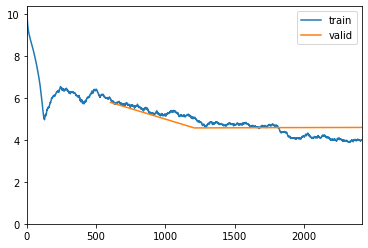

In [67]:
learn.fit_one_cycle(4, 1e-2)

In [68]:
del fr_vecs
del en_vecs
gc.collect()

8021

## 5.2 Bleu Metric

ในงาน Translation เนื่องจากภาษามนุษย์นั้นดิ้นได้ สมมติให้คน 2 คนแปลข้อความเดียวกัน เป็นไปได้ยากที่จะแปลออกมาเป็นประโยคเดียวกันตรงกันทุกคำ จึงไม่นิยมใช้ Metric ที่เปรียบเทียบคำต่อคำตรง ๆ แบบ Accuracy แต่นิยมใช้ Metric ที่เรียกว่า Bleu 

Bleu Score คืออะไร จะอธิบายต่อไป

In [0]:
class NGram():
    def __init__(self, ngram, max_n=50000): self.ngram, self.max_n = ngram, max_n
    def __eq__(self, other): 
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i, o in enumerate(self.ngram)]))

In [0]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [0]:
def get_correct_ngrams(pred, targ, n, max_n=5000): 
    pred_grams, targ_grams = get_grams(pred, n, max_n=max_n), get_grams(targ, n, max_n=max_n)
    pred_cnt, targ_cnt = Counter(pred_grams), Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g, c in pred_cnt.items()]), len(pred_grams)

In [0]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'

    def on_epoch_begin(self, **kwargs):
        self.pred_len, self.targ_len, self.corrects, self.counts = 0, 0, [0]*4, [0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred, targ in zip(last_output.cpu().numpy(), last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c, t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i] += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c, t in zip(self.corrects, self.counts)]
        len_penalty = exp(1 - self.targ_len / self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0] * precs[1] * precs[2] * precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)


In [0]:
learn = Learner(data, rnn, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))], callback_fns=[ShowGraph])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 6.92E-07


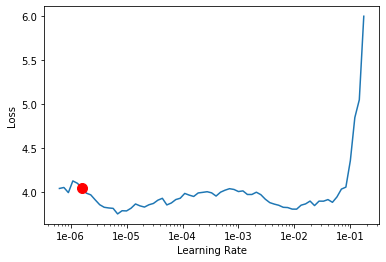

In [74]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,4.052882,4.578272,0.346954,0.251523,00:39
1,4.168340,5.156640,0.292388,0.241908,00:38
2,3.966556,4.972061,0.305129,0.246234,00:39
3,3.420474,4.322591,0.372252,0.283738,00:40


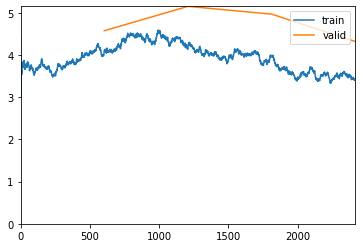

In [75]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,3.388816,4.190383,0.388151,0.300721,00:40
1,3.141425,4.036203,0.402735,0.307126,00:41
2,2.773793,3.928020,0.415567,0.318269,00:42


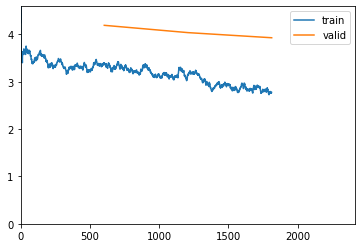

In [0]:
learn.fit_one_cycle(4, 1e-3)

## 6. View Result

In [0]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [], [], []
    with torch.no_grad():
        for xb, yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x, y, z in zip(xb, yb, out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs


In [0]:
inputs, targets, outputs = get_predictions(learn)

In [0]:
idx = 999
inputs[idx], targets[idx], outputs[idx]

In [0]:
idx = 1234
inputs[idx], targets[idx], outputs[idx]

ปัญหาคือ ถึงโมเดลจะเริ่มต้นได้ดี แต่แล้วก็จะออกทะเลไปเรื่อย ๆ กลายเป็นคำซ้ำ ๆ ไปจนจบ

# 5/2 Teacher Forcing

ในการเทรน Decoder ที่เป็น RNN ตามปกติจะนำ Output มา Feed กลับเป็น Input สำหรับคำต่อไป แต่ถ้า Output นั้นผิด กลับมาเป็น Input ทำให้ Output ต่อ ๆ ไปผิดเป็นโดมิโนไปหมด

Teacher Forcing คือ การเทรนด้วยแทนที่ จะ Feed Output จากโมเดล เป็น Input เราจะ การ Feed Output ที่ ถูกต้องให้กับโมเดล (Label) แล้วค่อย ๆ ปรับสัดส่วนเป็น Output จากโมเดลเพิ่มขึ้นเรื่อย ๆ ลด Label ลง

In [0]:
# class TeacherForcing(LearnerCallback):


# Credit

* https://www.youtube.com/watch?v=IfsjMg4fLWQ&list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9&index=12
* https://www.bualabs.com/archives/3103/what-is-recurrent-neural-network-rnn-pytorch-gru-nlp-ep-9/
* https://www.bualabs.com/archives/3087/sentiment-classification-deep-learning-imdb-movie-reviews-positive-negative-deep-neural-network-awd-lstm-ulmfit-nlp-ep-8/
* https://www.bualabs.com/archives/3060/what-is-n-gram-sentiment-classification-imdb-movie-review-naive-bayes-logistic-regression-nlp-ep-6/
* https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
* http://www.statmt.org/wmt15/translation-task.html
* https://fasttext.cc/docs/en/crawl-vectors.html
* https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213
* https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21
* https://github.com/fastai/fastai_docs/blob/master/dev_course/dl2/translation.ipynb
* 